In [1]:
import os

In [2]:
os.chdir('/home/ak/Projects/ature')

In [3]:
from commons.IMAGE import Image
from commons.ImgLATTICE import Lattice
import preprocess.utils.image_filters as fil
import preprocess.utils.image_utils as imgutil
import preprocess.utils.lattice_utils as lat
from commons.MAT import Mat
from PIL import Image as IMG

In [59]:
os.chdir('/home/ak/Projects/ature/data/av_wide_data_set')
file = Mat(file_name='wide_image_03.mat')
original = file.get_image('I2')[:,:,1]

In [16]:
img = Image(image_arr=original)

In [17]:
img.apply_bilateral()

INFO:root:Applying Bilateral filter.


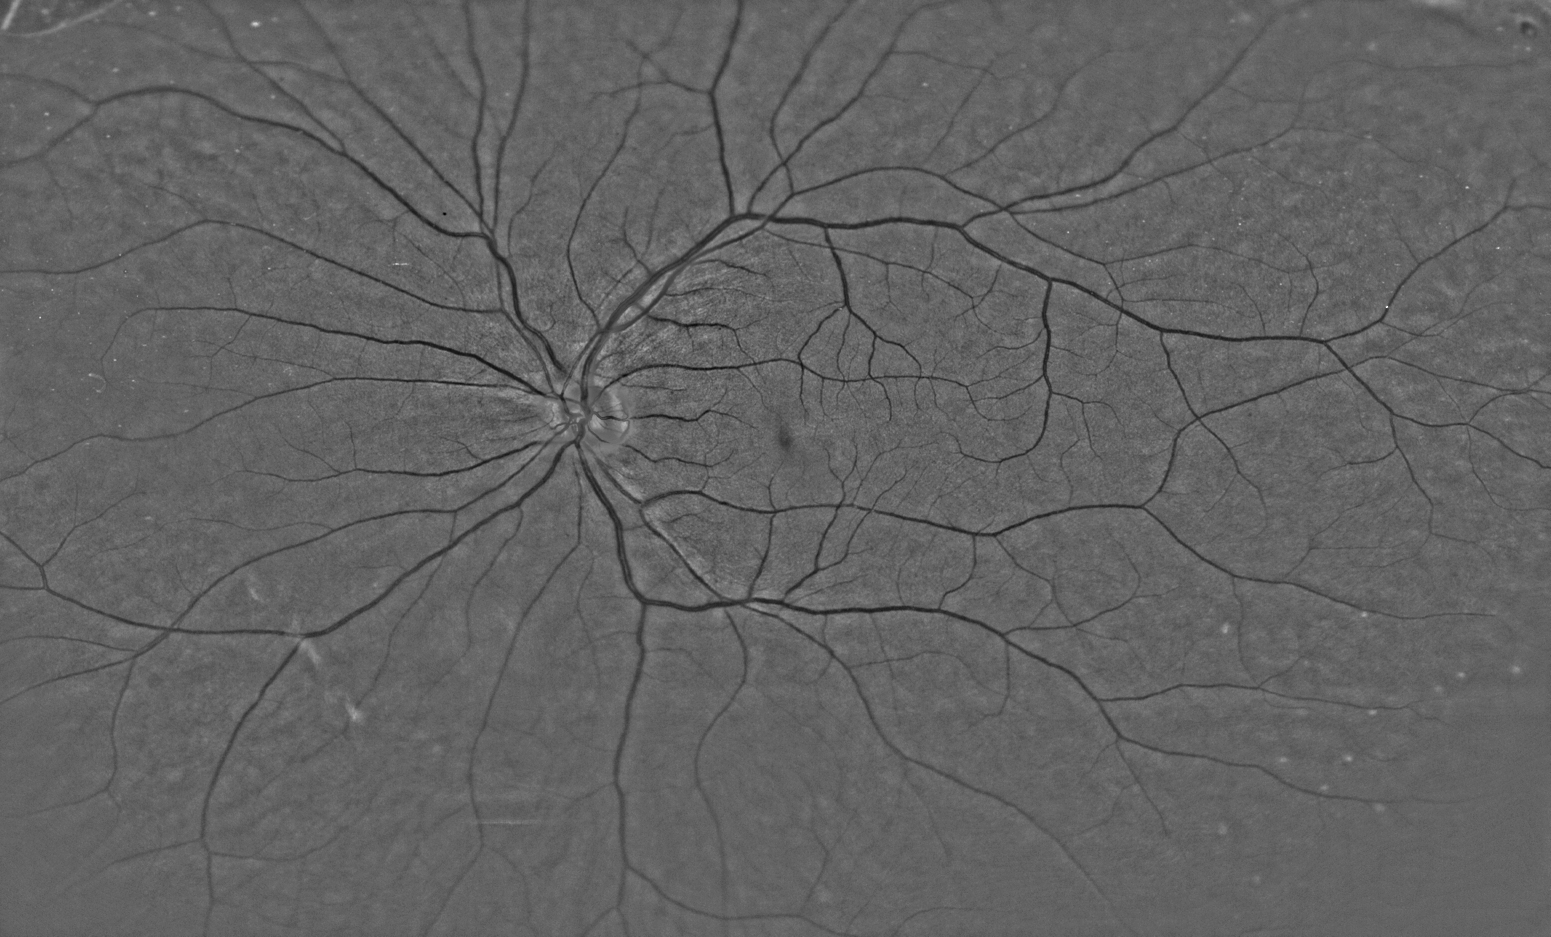

In [18]:
IMG.fromarray(img.diff_bilateral)

In [19]:
img.apply_gabor(kernel_bank= fil.get_chosen_gabor_bank())

INFO:root:Applying Gabor filter.


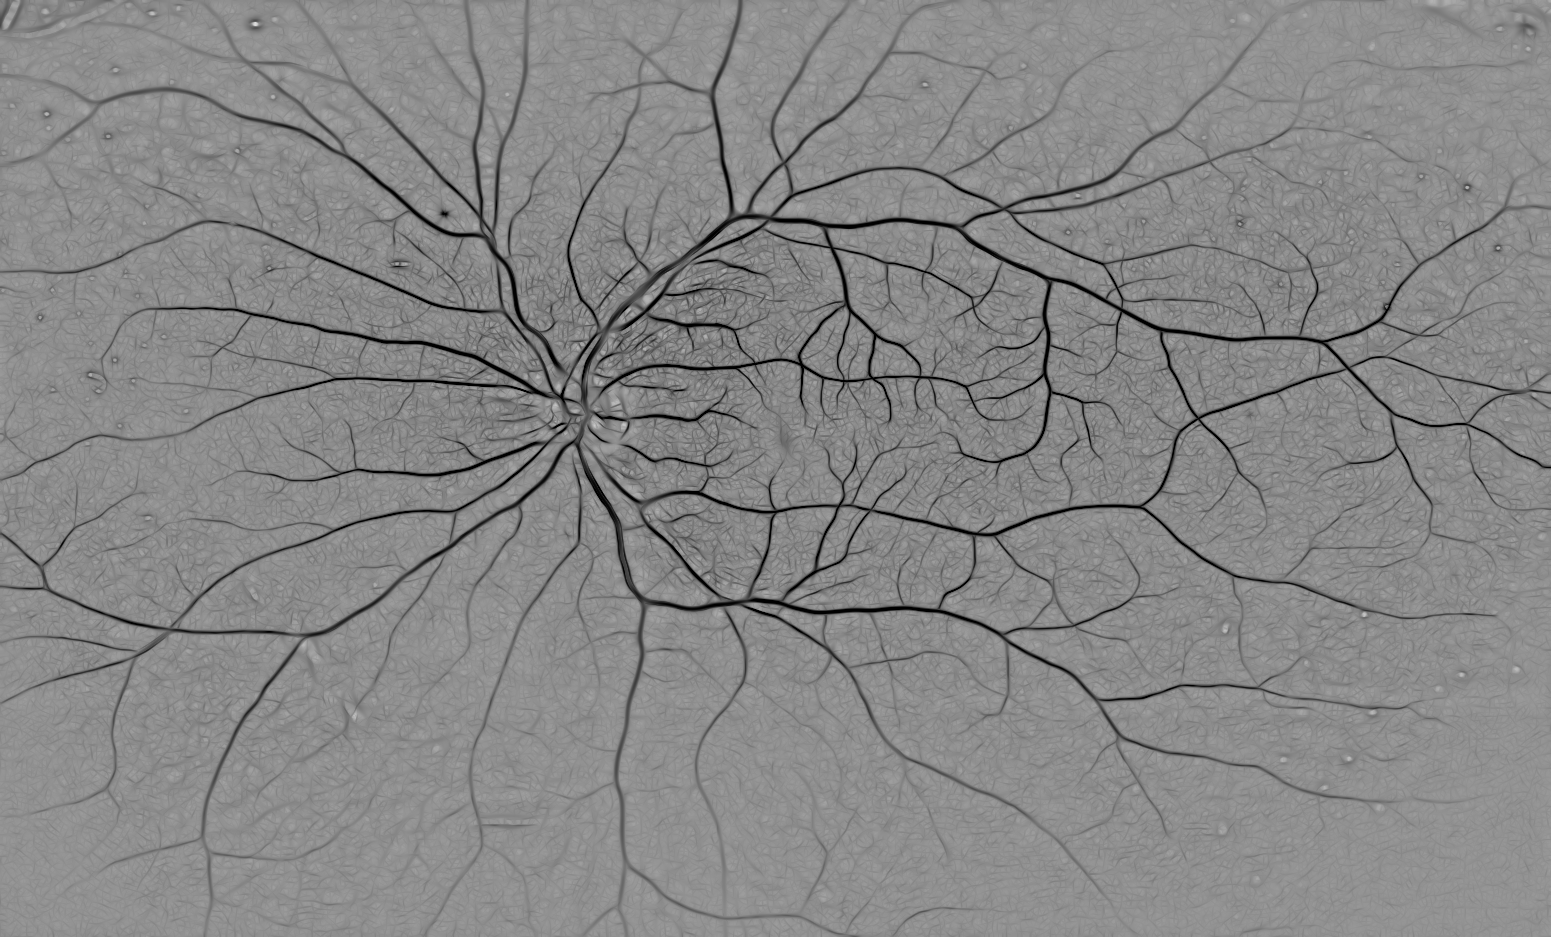

In [68]:
IMG.fromarray(img.img_gabor)

In [ ]:
# -------CONSTANTS--------
SKELETONIZE_THRESHOLD = 20

# Image lattice constants
IMG_LATTICE_EIGHT_CONNECTED = False
IMG_LATTICE_COST_ASSIGNMENT_ALPHA = 5

IMG_LATTICE_COST_ORIGINAL_IMAGE_CONTRIBUTION = 0.4
IMG_LATTICE_COST_GABOR_IMAGE_CONTRIBUTION = 0.6

# MST algorithm parameters
GRAPH_WEIGHT_METRICS = 'cost'
SEGMENTATION_THRESHOLD = 7.5

In [83]:
img.create_skeleton(threshold=SKELETONIZE_THRESHOLD, kernels=fil.get_chosen_skeleton_filter())
seed_node_list = lat.get_seed_node_list(img.img_skeleton)
len(seed_node_list)

1667

In [82]:
lattice = Lattice(image_arr_2d=img.img_gabor)

In [52]:
lattice.generate_lattice_graph(eight_connected=IMG_LATTICE_EIGHT_CONNECTED)

INFO:root:Creating 4-connected lattice.


------[ RUNNING Time: 14.13695764541626 seconds ]------


In [53]:
images =  [(IMG_LATTICE_COST_GABOR_IMAGE_CONTRIBUTION, img.img_gabor),(IMG_LATTICE_COST_ORIGINAL_IMAGE_CONTRIBUTION, img.img_array)]

In [55]:
lattice.assign_cost(images=images,alpha=IMG_LATTICE_COST_ASSIGNMENT_ALPHA)

------[ RUNNING Time: 96.67353129386902 seconds ]------


In [ ]:
import preprocess.algorithms.ature_mst as mst
# mst.run_mst(lattice_object=lattice,seed=seed_node_list, threshold=SEGMENTATION_THRESHOLD)

KeyboardInterrupt: 

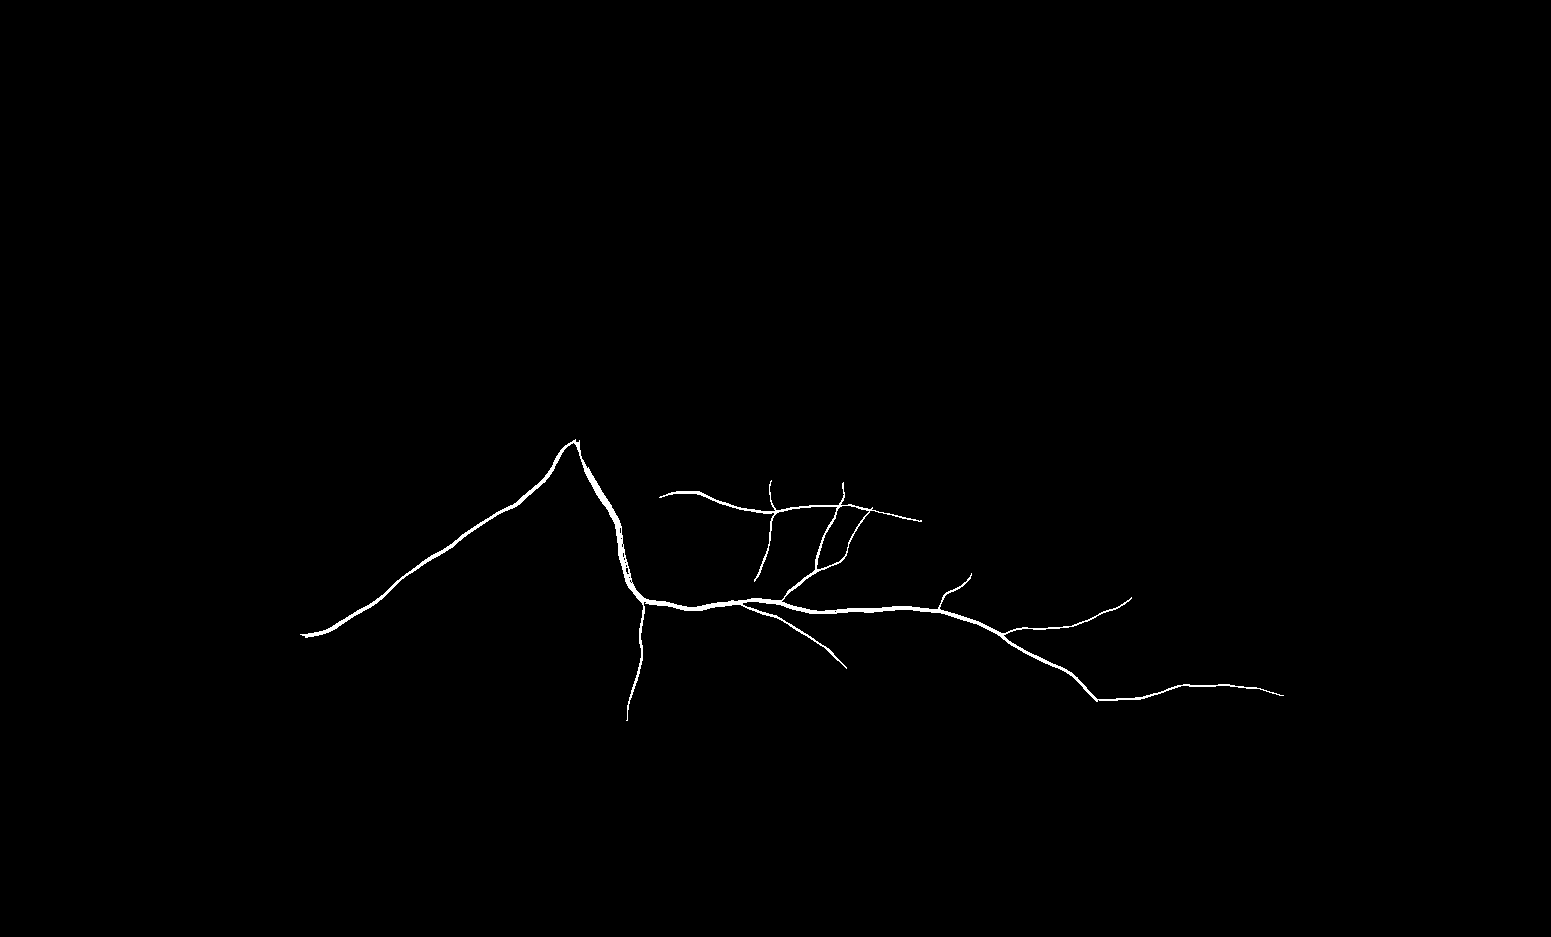

In [72]:
IMG.fromarray(lattice.accumulator)